In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense,Activation,Dropout
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from keras.callbacks import EarlyStopping
import math
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [2]:
hotel_details=pd.read_csv('./Hotel_details.csv',delimiter=',')
hotel_rooms=pd.read_csv('./Hotel_Room_attributes.csv',delimiter=',')
hotel_cost=pd.read_csv('./hotels_RoomPrice.csv',delimiter=',')


In [3]:
hotel_details.head()

,id,hotelid,hotelname,address,city,country,zipcode,propertytype,starrating,latitude,longitude,Source,url,curr
0,46406,1771651,Mediteran Bungalow Galeb,Vukovarska 7,Omis,Croatia,21310.0,Holiday parks,4,43.440124,16.682505,2,https://www.booking.com/hotel/hr/bungalow-luxu...,EUR
1,46407,177167,Hotel Polonia,Plac Teatralny 5,Torun,Poland,NaN,Hotels,3,53.012329,18.603800,5,https://www.agoda.com/en-gb/hotel-polonia/hote...,EUR
2,46408,1771675,Rifugio Sass Bece,"Belvedere del Pordoi,1",Canazei,Italy,38032.0,Hotels,3,46.477920,11.813350,2,http://www.booking.com/hotel/it/rifugio-sass-b...,EUR
3,46409,177168,Madalena Hotel,Mykonos,Mykonos,Greece,84600.0,Hotels,3,37.452316,25.329849,5,https://www.agoda.com/en-gb/madalena-hotel/hot...,EUR
4,46410,1771718,Pension Morenfeld,Mair im Korn Strasse 2,Lagundo,Italy,39022.0,Hotels,3,46.682780,11.131736,2,http://www.booking.com/hotel/it/pension-morenf...,EUR


In [4]:
hotel_rooms.head()

,id,hotelcode,roomamenities,roomtype,ratedescription
0,50677497,634876,Air conditioning: ;Alarm clock: ;Carpeting: ;C...,Double Room,"Room size: 15 m²/161 ft², Shower, 1 king bed"
1,50672149,8328096,Air conditioning: ;Closet: ;Fireplace: ;Free W...,Vacation Home,"Shower, Kitchenette, 2 bedrooms, 1 double bed ..."
2,50643430,8323442,Air conditioning: ;Closet: ;Dishwasher: ;Firep...,Vacation Home,"Shower, Kitchenette, 2 bedrooms, 1 double bed ..."
3,50650317,7975,Air conditioning: ;Clothes rack: ;Coffee/tea m...,Standard Triple Room,"Room size: 20 m²/215 ft², Shower, 3 single beds"
4,50650318,7975,Air conditioning: ;Clothes rack: ;Coffee/tea m...,Standard Triple Room,"Room size: 20 m²/215 ft², Shower, 3 single beds"


In [5]:
hotel_cost.head()

,id,refid,hotelcode,websitecode,dtcollected,ratedate,los,guests,roomtype,onsiterate,...,promoname,status_code,taxstatus,taxtype,taxamount,proxyused,israteperstay,mealinclusiontype,hotelblock,input_dtcollected
0,50677497,8646773,634876,5,2019-10-12 15:46:54,2019-11-02,1,1,Double Room,82.36,...,NaN,200,2,NaN,0.0,media:M3diAproxy@173.44.165.126:80,Y,Free Breakfast,NaN,2019-10-13
1,50672149,6234691,8328096,5,2019-10-12 15:47:45,2019-11-30,1,1,Vacation Home,636.09,...,NaN,200,2,NaN,0.0,media:M3diAproxy@173.44.164.126:80,Y,NaN,NaN,2019-10-13
2,50643430,7015677,8323442,5,2019-10-12 15:47:00,2019-12-20,1,1,Vacation Home,591.74,...,NaN,200,2,NaN,0.0,media:M3diAproxy@173.44.166.122:80,Y,NaN,NaN,2019-10-13
3,50650317,7327094,7975,5,2019-10-12 15:47:02,2019-12-28,1,1,Standard Triple Room,881.48,...,NaN,200,2,Tax 20%,0.0,media:M3diAproxy@209.242.219.141:80,Y,NaN,NaN,2019-10-13
4,50650318,7327094,7975,5,2019-10-12 15:47:02,2019-12-28,1,1,Standard Triple Room,897.53,...,NaN,200,2,VAT $ 179.51,0.0,media:M3diAproxy@209.242.219.141:80,Y,Free breakfast for {3},NaN,2019-10-13


In [6]:
#data cleaning and transformation
del hotel_details['id']
del hotel_rooms['id']
del hotel_details['zipcode']

In [7]:
hotel_details=hotel_details.dropna()
hotel_rooms=hotel_rooms.dropna()

In [8]:
hotel_details.drop_duplicates(subset='hotelid',keep=False,inplace=True)

In [9]:
hotel=pd.merge(hotel_rooms,hotel_details,left_on='hotelcode',right_on='hotelid',how='inner')

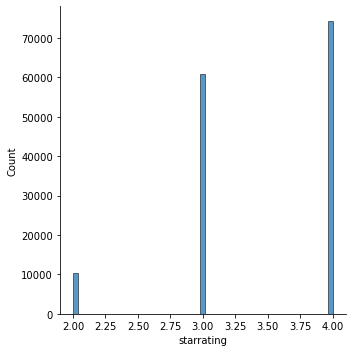

In [12]:
import seaborn as sns
sns.displot(hotel['starrating'])
plt.show()

In [11]:
hotel.columns

Index(['hotelcode', 'roomamenities', 'roomtype', 'ratedescription', 'hotelid',
       'hotelname', 'address', 'city', 'country', 'propertytype', 'starrating',
       'latitude', 'longitude', 'Source', 'url', 'curr'],
      dtype='object')

In [15]:
#checking corelation between various attributes.
#After creating new features and removing the features that are not useful, we want to know if anything correlates well with starrating .This will tell us if we should pay more attention to any particular features.
hotel.corr()
hotel[hotel.columns[1:]].corr()['starrating'][:]

hotelid      -0.011069
starrating    1.000000
latitude     -0.006816
longitude    -0.017570
Source             NaN
Name: starrating, dtype: float64

In [19]:
del hotel['hotelid']
del hotel['url']
del hotel['curr']
del hotel['Source']

In [22]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [23]:
hotel.isnull().sum()

hotelcode          0
roomamenities      0
roomtype           0
ratedescription    0
hotelname          0
address            0
city               0
country            0
propertytype       0
starrating         0
latitude           0
longitude          0
dtype: int64

In [24]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [25]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
  
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {"correlation matrix"}', fontsize=15)
    plt.show()

In [26]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [29]:
nRowsRead = 1000 # specify 'None' if want to read whole file

nRow, nCol = hotel_details.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 99154 rows and 12 columns


C:\Users\Admin\AppData\Local\Temp\ipykernel_15644\3497257782.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns') # drop columns with NaN


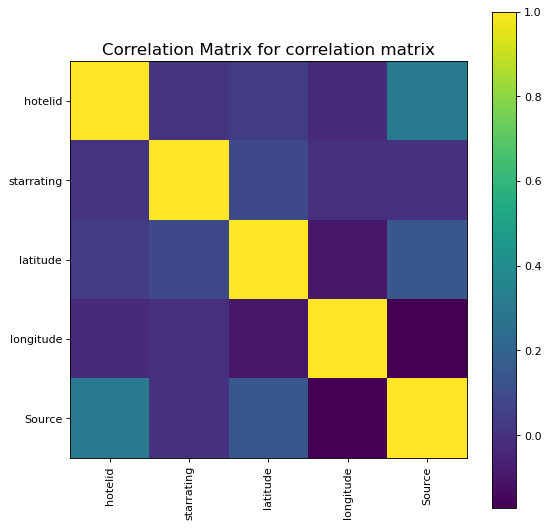

In [38]:
plotCorrelationMatrix(hotel_details, 8)

C:\Users\Admin\AppData\Local\Temp\ipykernel_15644\3497257782.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns') # drop columns with NaN


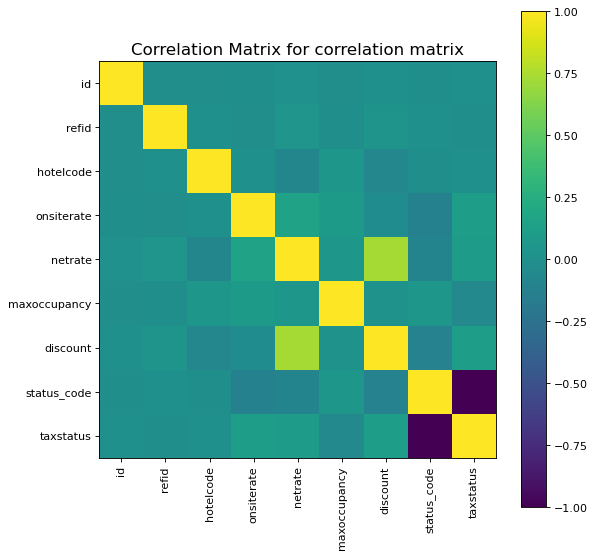

In [40]:
plotCorrelationMatrix(hotel_cost, 8)

In [42]:
hotel.columns

Index(['hotelcode', 'roomamenities', 'roomtype', 'ratedescription',
       'hotelname', 'address', 'city', 'country', 'propertytype', 'starrating',
       'latitude', 'longitude'],
      dtype='object')

In [43]:
#Recommender system based only on City and ratings about the hotel.
def citybased(city):
    hotel['city']=hotel['city'].str.lower()
    citybase=hotel[hotel['city']==city.lower()]
    citybase=citybase.sort_values(by='starrating',ascending=False)
    citybase.drop_duplicates(subset='hotelcode',keep='first',inplace=True)
    if(citybase.empty==0):
        hname=citybase[['hotelname','starrating','address','roomamenities','ratedescription']]
        return hname.head()
    else:
        print('No Hotels Available')


In [44]:
print('Top 5 hotels')
citybased('London')

Top 5 hotels


,hotelname,starrating,address,roomamenities,ratedescription
48985,The Colonnade London Hotel,4,2 Warrington Crescent,Additional toilet: ;Air conditioning: ;Alarm c...,"Room size: 28 m²/301 ft², Balcony/terrace, Non..."
58663,South Point Suites - London Bridge,4,Bermondsey Street,Air conditioning: ;Alarm clock: ;Blackout curt...,"Room size: 24 m²/258 ft², Street view, Non-smo..."
106943,Doubletree by Hilton London Chelsea,4,Imperial Road Imperial Wharf,Air conditioning: ;Alarm clock: ;Blackout curt...,"Room size: 20 m²/215 ft², Street view, Non-smo..."
57452,Sir Christopher Wren Hotel & Spa,4,Unknown,Air conditioning: ;Alarm clock: ;Bathrobes: ;B...,"Room size: 25 m²/269 ft², Non-smoking, Shower ..."
92479,The Manor Hotel Heathrow,4,"Village Green, Datchet,",Additional bathroom: ;Additional toilet: ;Air ...,"Shower and bathtub, 1 double bed"


In [45]:
room_no=[
     ('king',2),
   ('queen',2), 
    ('triple',3),
    ('master',3),
   ('family',4),
   ('murphy',2),
   ('quad',4),
   ('double-double',4),
   ('mini',2),
   ('studio',1),
    ('junior',2),
   ('apartment',4),
    ('double',2),
   ('twin',2),
   ('double-twin',4),
   ('single',1),
     ('diabled',1),
   ('accessible',1),
    ('suite',2),
    ('one',2)
   ]

In [46]:
def calc():
    guests_no=[]
    for i in range(hotel.shape[0]):
        temp=hotel['roomtype'][i].lower().split()
        flag=0
        for j in range(len(temp)):
            for k in range(len(room_no)):
                if temp[j]==room_no[k][0]:
                    guests_no.append(room_no[k][1])
                    flag=1
                    break
            if flag==1:
                break
        if flag==0:
            guests_no.append(2)
    hotel['guests_no']=guests_no

calc()

In [47]:
def pop_citybased(city,number):
    hotel['city']=hotel['city'].str.lower()
    popbased=hotel[hotel['city']==city.lower()]
    popbased=popbased[popbased['guests_no']==number].sort_values(by='starrating',ascending=False)
    popbased.drop_duplicates(subset='hotelcode',keep='first',inplace=True)
    if popbased.empty==True:
        print('Sorry No Hotels Available\n tune your constraints')
    else:
        return popbased[['hotelname','roomtype','guests_no','starrating','address','roomamenities','ratedescription']].head(10)

In [48]:
pop_citybased('London',4)

,hotelname,roomtype,guests_no,starrating,address,roomamenities,ratedescription
1440,Holiday Inn London - Heathrow T5,Family Room,4,4,Old Bath Road,Air conditioning: ;Alarm clock: ;Blackout curt...,"Room size: 25 m²/269 ft², Non-smoking, Separat..."
53496,Mercure London Hyde Park Hotel,Family Room,4,4,8-14 Talbot Square,Air conditioning: ;Desk: ;Free Wi-Fi in all ro...,"Room size: 31 m²/334 ft², Non-smoking, 1 singl..."
60734,Hallmark Hotel London Chigwell Prince Regent,Executive Family Room,4,4,Manor Road,Air conditioning: ;Carpeting: ;Closet: ;Clothe...,"Non-smoking, Shower and bathtub, 1 double bed"
107246,Radisson Blu Edwardian Kenilworth - Bloomsbury,Family Room 2 adults + 2 children,4,4,97 Great Russell Street,Air conditioning: ;Alarm clock: ;Bathrobes: ;C...,"Room size: 20 m²/215 ft², Non-smoking, Shower ..."
55913,Acorn Lodge Gatwick,Family Stay & Park 8 Days,4,4,"79 Massetts Road, Horley",Air conditioning: ;Carpeting: ;Closet: ;Coffee...,"Shower, 1 double bed and 1 bunk bed"
64171,Gatwick Cambridge Hotel,Family Room,4,4,"19 Bonehurst Road, Horley",Air conditioning: ;Alarm clock: ;Carpeting: ;C...,"Room size: 15 m²/161 ft², Non-smoking, Shower ..."
96611,Trumbles Gatwick B&B,Family Room (2 Adults and 2 Children) - Number 6,4,4,Stan Hill,Air conditioning: ;Alarm clock: ;Carpeting: ;C...,"Room size: 18 m²/194 ft², Shower and bathtub, ..."
97400,Heathrow/Windsor Marriott Hotel,"Deluxe Room, Guest room, 2 Double, Family Room",4,4,"Ditton Road, Langley",Air conditioning: ;Alarm clock: ;Carpeting: ;C...,"Room size: 30 m²/323 ft², Non-smoking, Shower ..."
65811,Atrium Hotel Heathrow,Family 1,4,4,Great south-west road Feltham,Additional toilet: ;Air conditioning: ;Alarm c...,"Room size: 28 m²/301 ft², Shower, 2 single bed..."
112259,The Level at Melia White House,The Level Family Room,4,4,Albany Street,Air conditioning: ;Bathrobes: ;Blackout curtai...,"Shower and bathtub, Executive lounge access, 1..."


In [49]:
hotel['roomamenities']=hotel['roomamenities'].str.replace(': ;',',')

In [50]:
def requirementbased(city,number,features):
    hotel['city']=hotel['city'].str.lower()
    hotel['roomamenities']=hotel['roomamenities'].str.lower()
    features=features.lower()
    features_tokens=word_tokenize(features)  
    sw = stopwords.words('english')
    lemm = WordNetLemmatizer()
    f1_set = {w for w in features_tokens if not w in sw}
    f_set=set()
    for se in f1_set:
        f_set.add(lemm.lemmatize(se))
    reqbased=hotel[hotel['city']==city.lower()]
    reqbased=reqbased[reqbased['guests_no']==number]
    reqbased=reqbased.set_index(np.arange(reqbased.shape[0]))
    l1 =[];l2 =[];cos=[];
    #print(reqbased['roomamenities'])
    for i in range(reqbased.shape[0]):
        temp_tokens=word_tokenize(reqbased['roomamenities'][i])
        temp1_set={w for w in temp_tokens if not w in sw}
        temp_set=set()
        for se in temp1_set:
            temp_set.add(lemm.lemmatize(se))
        rvector = temp_set.intersection(f_set)
        #print(rvector)
        cos.append(len(rvector))
    reqbased['similarity']=cos
    reqbased=reqbased.sort_values(by='similarity',ascending=False)
    reqbased.drop_duplicates(subset='hotelcode',keep='first',inplace=True)
    return reqbased[['hotelname','roomtype','guests_no','starrating','address','roomamenities','ratedescription','similarity']].head(10)

In [51]:
#Requirement And special needs based Recommender
requirementbased('London',1,'I need a extra toilet and room should be completely air conditioned.I should have a bathrobe.')

,hotelname,roomtype,guests_no,starrating,address,roomamenities,ratedescription,similarity
310,The Colonnade London Hotel,Studio,1,4,2 Warrington Crescent,"additional toilet,air conditioning,alarm clock...","Room size: 28 m²/301 ft², Balcony/terrace, Non...",4
819,Amba Hotel Charing Cross,Studio King Suite,1,4,The Strand,"air conditioning,alarm clock,bathrobes,carpeti...","Room size: 34 m²/366 ft², Non-smoking, Shower ...",3
793,Holiday Inn Express Park Royal,2 Single Beds Non-smoking,1,3,Victoria RoadNorth Acton,"air conditioning,alarm clock,carpeting,closet,...","Room size: 25 m²/269 ft², Non-smoking, Shower,...",3
816,Simply Rooms & Suites Hotel,Deluxe Studio Suite,1,4,21 Avonmore Road,"additional toilet,air conditioning,cleaning pr...","Room size: 20 m²/215 ft², City view, Non-smoki...",3
912,The Cleveland Hotel,Single Room - Basic,1,4,39-40 Cleveland Square,"air conditioning,carpeting,closet,clothes rack...","Room size: 14 m²/151 ft², Non-smoking, Shower,...",3
408,South Point Suites - London Bridge,Deluxe Studio Suite,1,4,Bermondsey Street,"additional bathroom,additional toilet,air cond...","Room size: 45 m²/484 ft², 2 bathrooms, Shower,...",3
883,Angus Hotel,Single - Non-Smoking,1,2,31-32 Argyle square,"additional toilet,air conditioning,carpeting,c...","Street view, Non-smoking, Shower, 1 double bed",3
462,Pestana Chelsea Bridge Hotel And Spa,Accessible Twin Bedroom,1,4,354 Queenstown Road,"air conditioning,alarm clock,bathrobes,blackou...","Room size: 30 m²/323 ft², City view, Non-smoki...",3
494,Park Plaza London Waterloo,Studio King,1,4,6 Hercules Road,"air conditioning,alarm clock,bathrobes,blackou...","Room size: 24 m²/258 ft², City view, Non-smoki...",3
323,Park International Hotel,Standard Single Room,1,4,117-129 Cromwell Road,"additional toilet,air conditioning,blackout cu...","Room size: 11 m²/118 ft², Non-smoking, Shower,...",3
